In [1]:
# libraries
import sys
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
from lightfm import LightFM
from tqdm import tqdm

c:\Users\fer\.pyenv\pyenv-win\versions\3.7.4\lib\site-packages\lightfm\_lightfm_fast.py:10: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  "LightFM was compiled without OpenMP support. "


# Exploratory Data Analysis (EDA)

In [2]:
# load train dataset
train = pd.read_csv('./data/train.csv')
print(f'train shape: {train.shape}')
train.head(3)

train shape: (3657801, 7)


,customer_id,account_id,device_type,asset_id,tunein,tuneout,resume
0,0,90627,STATIONARY,18332.0,2021-02-18 22:52:00.0,2021-02-18 23:35:00.0,0
1,0,90627,STATIONARY,24727.0,2021-03-24 23:17:00.0,2021-03-25 00:01:00.0,0
2,1,3387,STB,895.0,2021-03-15 10:05:00.0,2021-03-15 10:23:00.0,0


In [3]:
# load metadata dataset
metadata = pd.read_csv('./data/metadata.csv', sep=';')
print(f'metadata shape: {metadata.shape}')
metadata.head(3)

metadata shape: (33144, 30)


,asset_id,content_id,title,reduced_title,episode_title,show_type,released_year,country_of_origin,category,keywords,...,language_rating,dialog_rating,fv_rating,pay_per_view,pack_premium_1,pack_premium_2,create_date,modify_date,start_vod_date,end_vod_date
0,15188,0.0,Ep:17 Tiempos Compulsivos,Tiempos_Compul_E17,Episodio 17,Serie,2012.0,AR,Drama,"Trastornos,Médicos,Tragicómica,Telenovela,Enfe...",...,N,N,N,N,N,N,2017-12-01T10:18:15.0Z,2019-01-26T06:37:18.0Z,2017-12-01T00:00:00.0Z,2020-12-01T23:59:59.0Z
1,24940,1.0,7 Cajas,7_Cajas,NaN,Película,2012.0,PY,Suspenso/Acción,"Latinoamérica,Pobreza,Crimen,Pandillas",...,N,N,N,Y,N,N,2017-12-19T20:58:15.0Z,2019-09-17T19:02:03.0Z,2017-12-15T00:00:00.0Z,2022-12-14T23:59:59.0Z
2,21939,2.0,La Maldición de las Hormigas Gigantes,La_Maldicion_de_las,NaN,Película,2016.0,FI,Terror/Comedia,"Criaturas,Plagas,Adolescentes,Fantasía,Video J...",...,N,N,N,N,N,N,2018-02-16T13:51:07.0Z,2020-04-28T14:16:38.0Z,2018-01-25T00:00:00.0Z,2020-12-01T23:59:59.0Z


In [4]:
# merging datasets
df = pd.merge(left=train, right=metadata,
              left_on='asset_id', right_on='asset_id',
              how='left'
              )
print(f'df shape: {df.shape}')

df shape: (3657801, 36)


In [5]:
# feature selection
df = df[['customer_id', 'account_id', 'device_type', 'asset_id', 'tunein',
       'tuneout', 'resume', 'content_id', 'reduced_title',
       'show_type', 'run_time_min', 'end_vod_date']]

In [6]:
# checking dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3657801 entries, 0 to 3657800
Data columns (total 12 columns):
 #   Column         Dtype  
---  ------         -----  
 0   customer_id    int64  
 1   account_id     int64  
 2   device_type    object 
 3   asset_id       float64
 4   tunein         object 
 5   tuneout        object 
 6   resume         int64  
 7   content_id     float64
 8   reduced_title  object 
 9   show_type      object 
 10  run_time_min   float64
 11  end_vod_date   object 
dtypes: float64(3), int64(3), object(6)
memory usage: 362.8+ MB


In [7]:
# checking missing values
df.isna().mean()*100

customer_id      0.000000
account_id       0.000000
device_type      0.000793
asset_id         0.000601
tunein           0.000000
tuneout          0.000000
resume           0.000000
content_id       0.003882
reduced_title    0.000601
show_type        0.000957
run_time_min     0.000601
end_vod_date     0.000601
dtype: float64

In [8]:
# removing na
print(f'Number of rows before drop duplicates: {len(df)}')
df = df.dropna()
print(f'Number of rows after drop duplicates: {len(df)}')

Number of rows before drop duplicates: 3657801
Number of rows after drop duplicates: 3657617


In [9]:
# checking and removing of duplicates
print(f'Number of rows before drop duplicates: {len(df)}')
df = df.drop_duplicates(keep='first')
print(f'Number of rows after drop duplicates: {len(df)}')

Number of rows before drop duplicates: 3657617
Number of rows after drop duplicates: 3657579


In [10]:
# transforming dates in datetime object
df['tunein'] = pd.to_datetime(df['tunein'], format='%Y-%m-%d %H:%M:%S')
df['tuneout'] = pd.to_datetime(df['tuneout'], format='%Y-%m-%d %H:%M:%S')
df['end_vod_date'] = pd.to_datetime(df['end_vod_date'], format='%Y-%m-%dT%H:%M:%S')\
    .dt.tz_localize(None) # Z at the ends of str indicates Zulú UTC, so i need to removeethe timezone

# calculate time_watched (difference between tuneout - tunein)
df['time_watched'] = df['tuneout'] - df['tunein']
# transform time_watched (minutes) to time_watched_seconds (seconds)
df['time_watched_seconds'] = df['time_watched'].apply(lambda x: x.seconds)

# transform run_time (minutes) to run_time_seconds (seconds)
df['run_time_seconds'] = df['run_time_min']*60

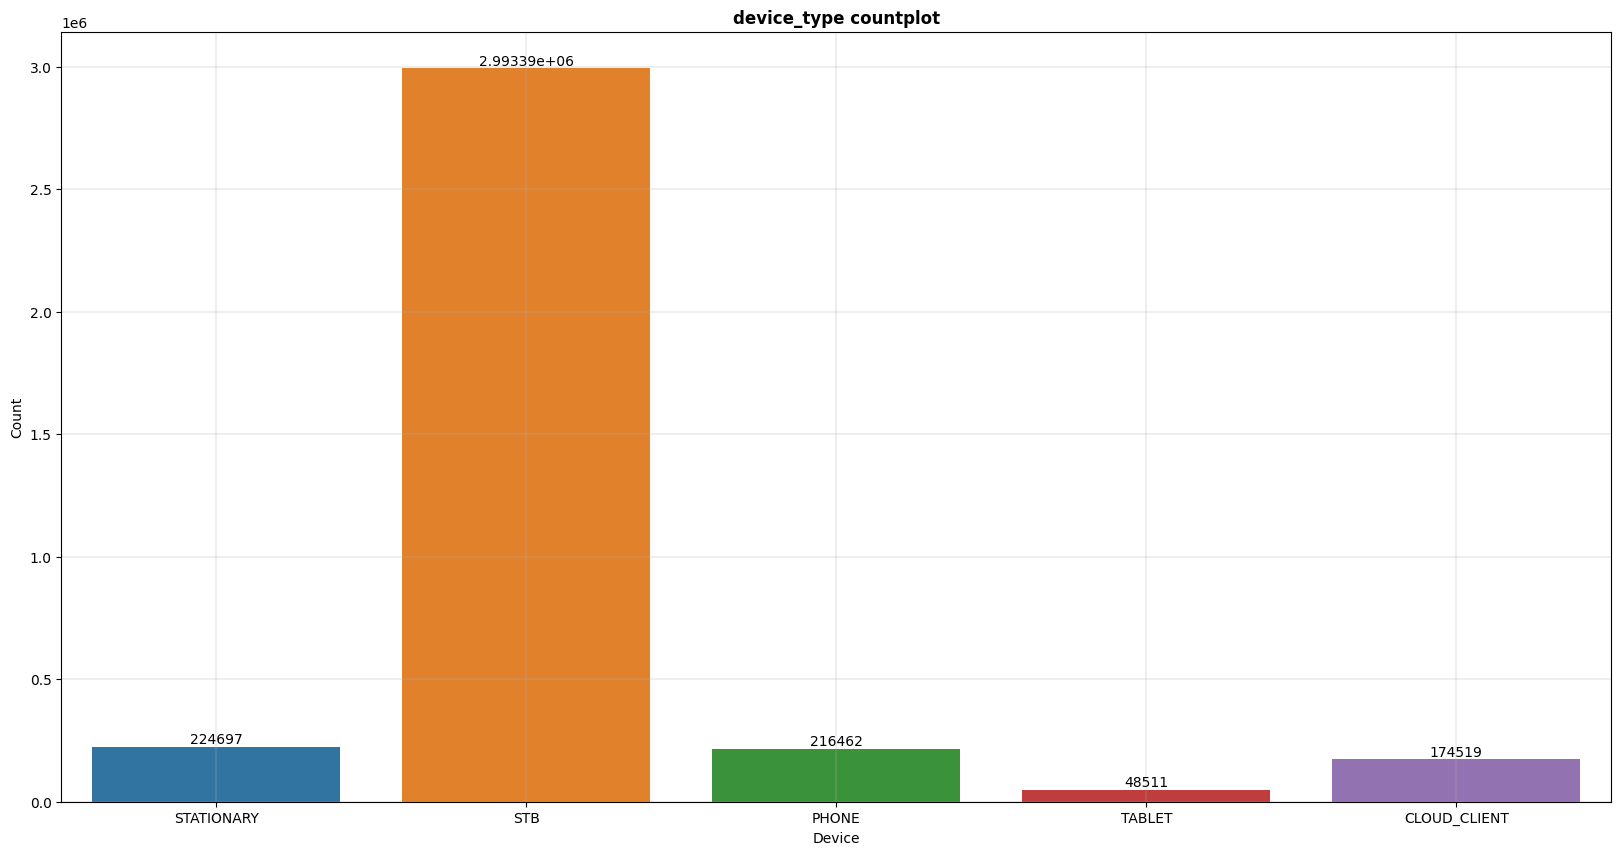

In [11]:
# ploting device_type
plt.figure(figsize=(20, 10))
ax = sns.countplot(data=df, x='device_type')
for container in ax.containers:
    ax.bar_label(container)
plt.xlabel('Device')
plt.ylabel('Count')
plt.grid(linewidth=0.3)
plt.title('device_type countplot', fontdict={'fontsize': 12,'fontweight':'bold'})
plt.show()

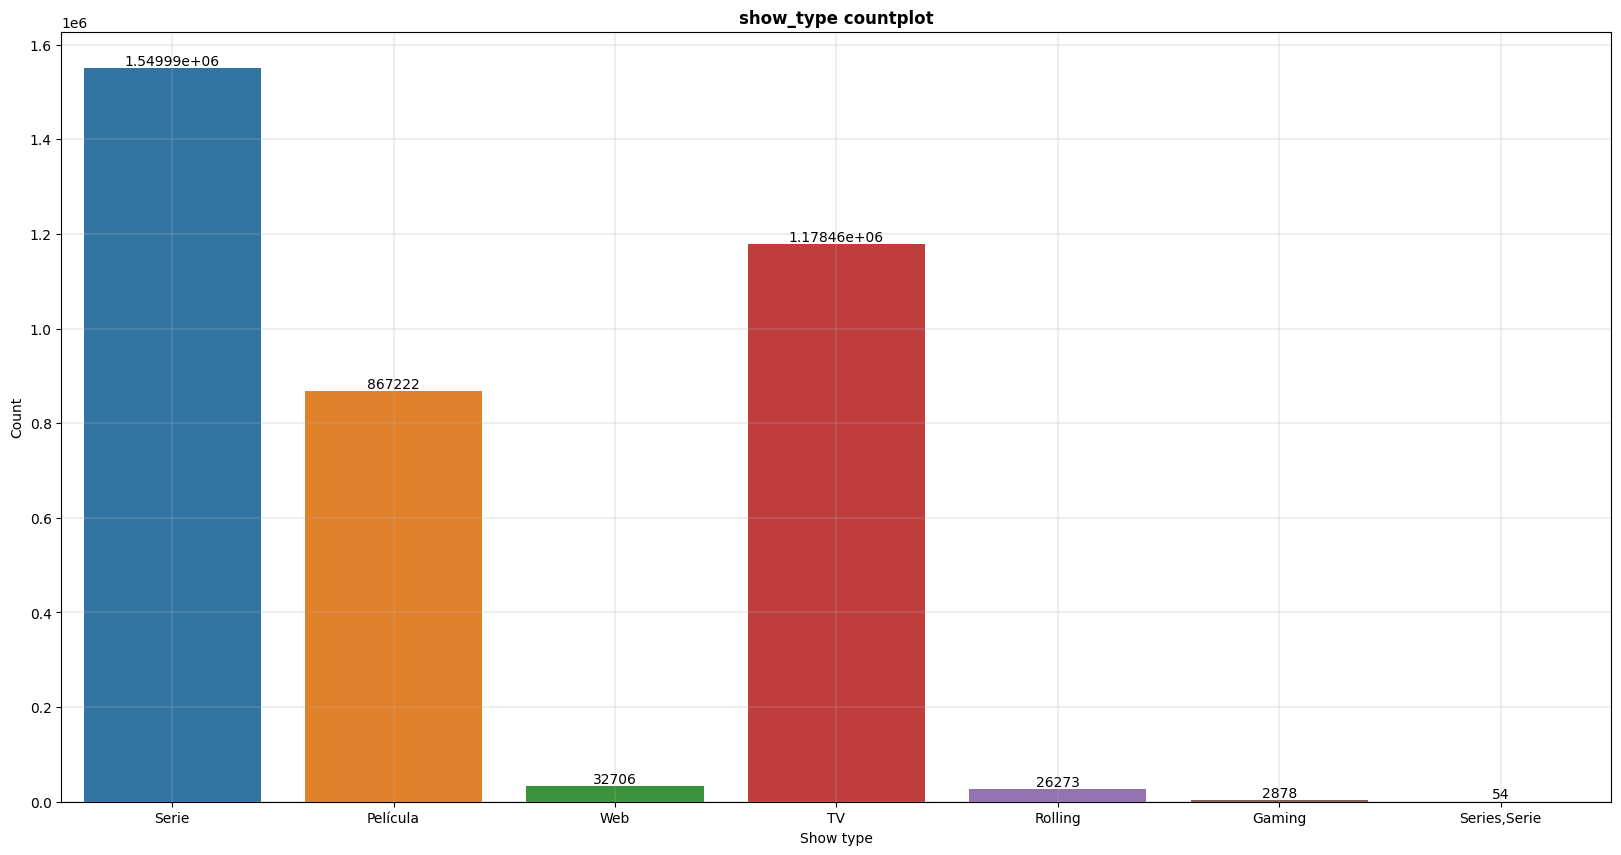

In [12]:
# ploting show_type
plt.figure(figsize=(20, 10))
ax = sns.countplot(data=df, x='show_type')
for container in ax.containers:
    ax.bar_label(container)
plt.xlabel('Show type')
plt.ylabel('Count')
plt.grid(linewidth=0.3)
plt.title('show_type countplot', fontdict={'fontsize': 12,'fontweight':'bold'})
plt.show()

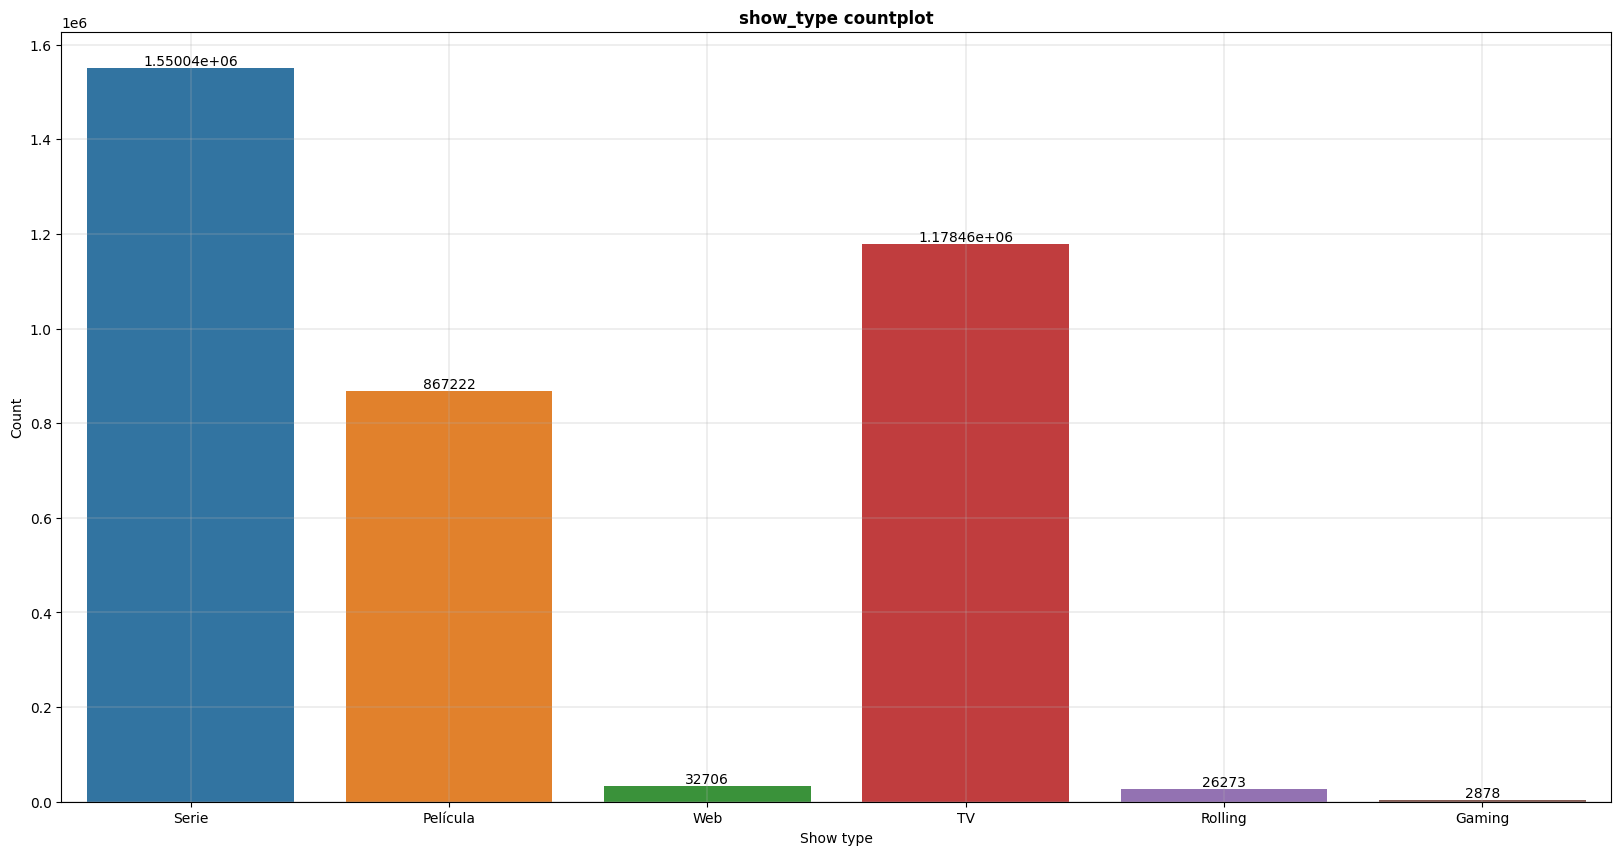

In [13]:
# modify 'Series,Serie' show_type category
df['show_type'] = df['show_type'].apply(lambda x: 'Serie' if x == 'Series,Serie' else x)

# ploting show_type
plt.figure(figsize=(20, 10))
ax = sns.countplot(data=df, x='show_type')
for container in ax.containers:
    ax.bar_label(container)
plt.xlabel('Show type')
plt.ylabel('Count')
plt.grid(linewidth=0.3)
plt.title('show_type countplot', fontdict={'fontsize': 12,'fontweight':'bold'})
plt.show()

In [14]:
# customers, accounts, assets and contents
print(f'Number of unique customers: {df["customer_id"].nunique()}')
print(f'Number of unique accounts: {df["account_id"].nunique()}')
print(f'Number of unique assets: {df["asset_id"].nunique()}')
print(f'Number of unique contents: {df["content_id"].nunique()}')

Number of unique customers: 112332
Number of unique accounts: 113873
Number of unique assets: 23975
Number of unique contents: 4062


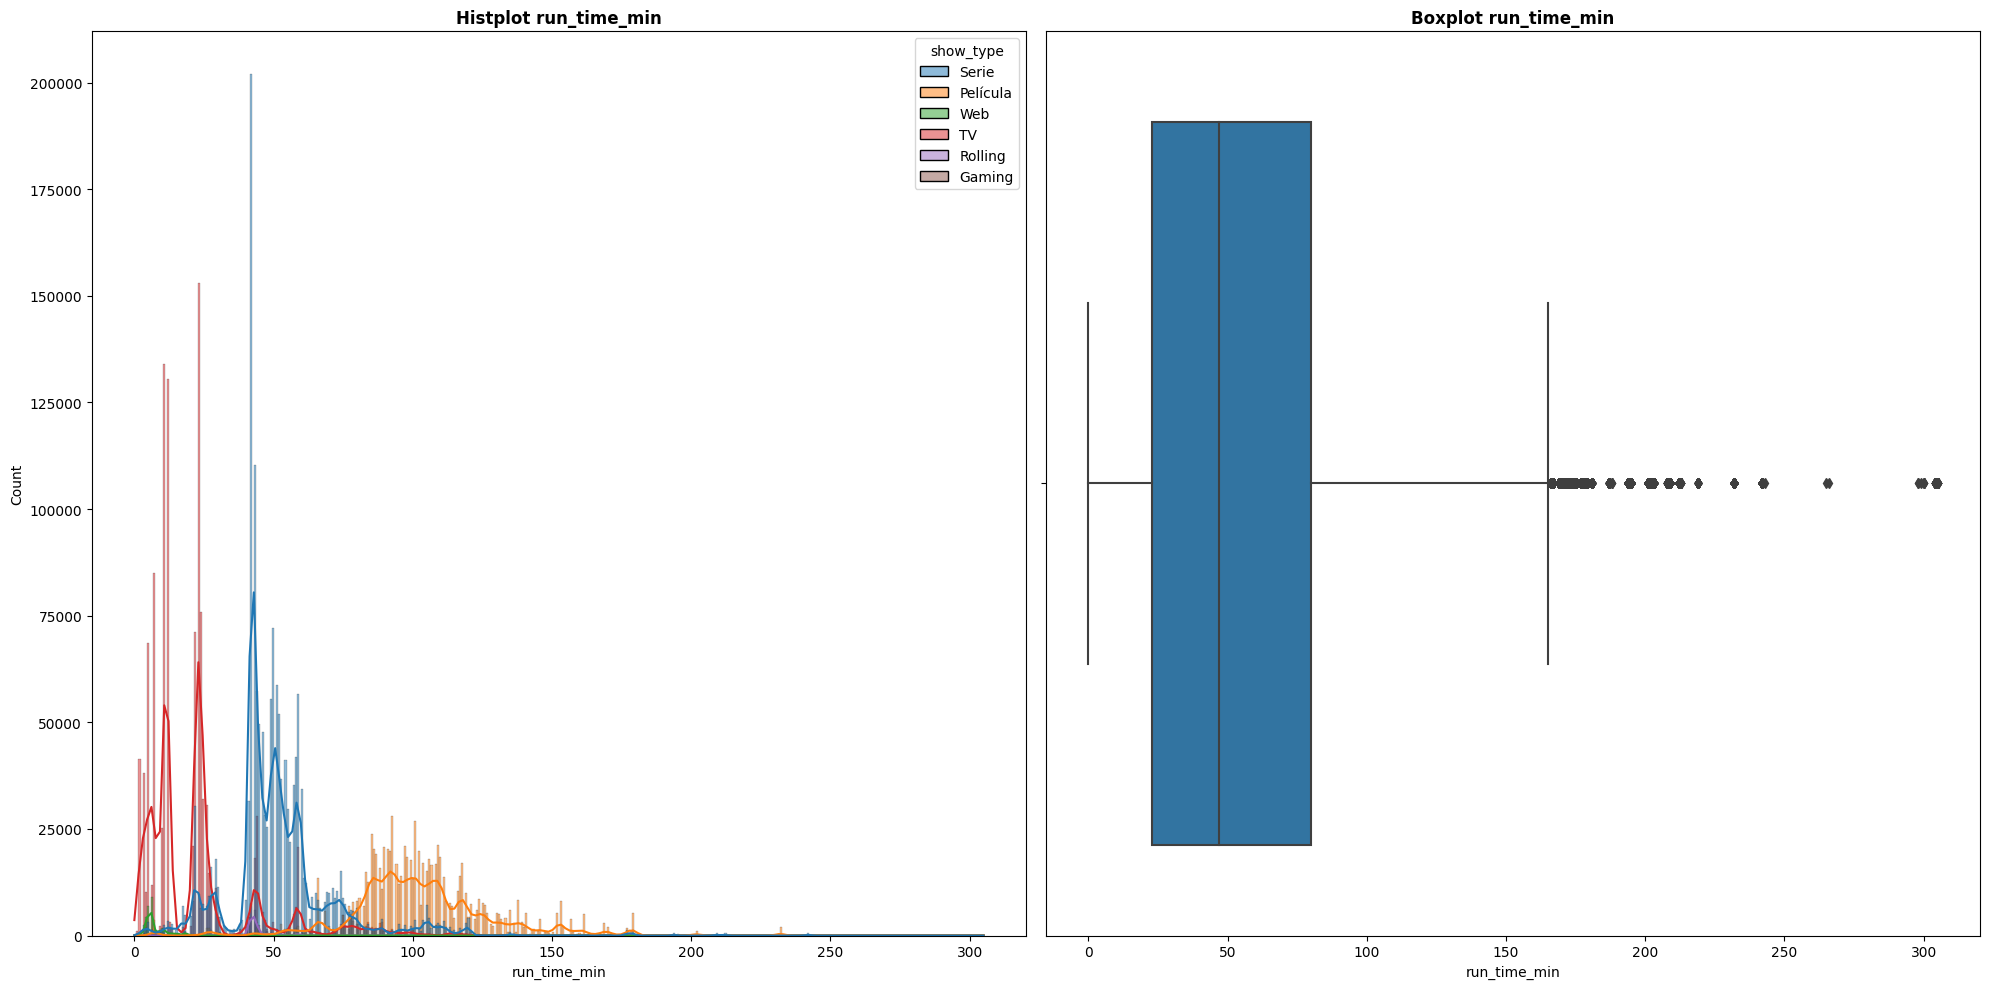

In [15]:
# checking assets duration
numerical_features = ['run_time_min']
fig, ax = plt.subplots(nrows=len(numerical_features), ncols=2, figsize=(20, 10))

for i, feature in enumerate(numerical_features):
    ax[0] = sns.histplot(x=df[feature], ax=ax[0], kde=True, hue=df['show_type'])
    ax[0].set_title(f'Histplot {feature}',fontdict={'fontsize': 12,'fontweight':'bold'})
    ax[1] = sns.boxplot(x=df[feature], ax=ax[1])
    ax[1].set_title(f'Boxplot {feature}',fontdict={'fontsize': 12,'fontweight':'bold'})

plt.tight_layout()
plt.show()

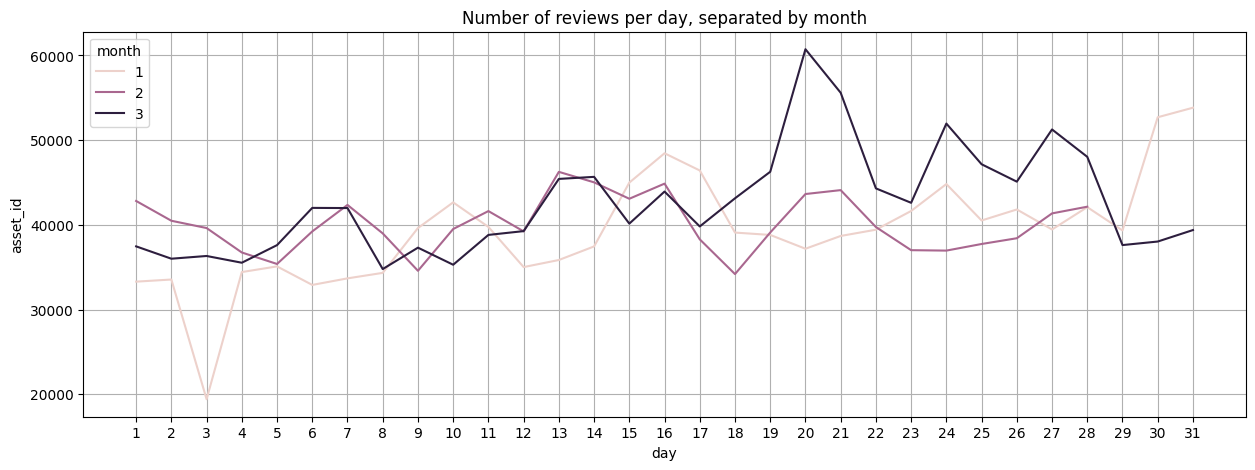

In [16]:
# ploting visualizations/day-month
aux = df.copy()
aux['year'] = df['tunein'].dt.year
aux['month'] = df['tunein'].dt.month
aux['day'] = df['tunein'].dt.day
aux = aux.groupby(['month', 'day'], as_index=False).count()[['month', 'day', 'asset_id']]

plt.figure(figsize=(15,5))
sns.lineplot(data=aux, x='day', y='asset_id', hue='month')
plt.title("Number of reviews per day, separated by month")
plt.xticks([x for x in range(aux['day'].min(), aux['day'].max() +1,1)])
plt.grid(0.3)
plt.show()

## calculating the implicit rate from 'run_time', 'tunein'/'tuneout' and 'resume'

In [18]:
# the user liked the asset if he/she watched more than 80% of the asset's duration
df['rate_watch'] = df['run_time_seconds']*0.80 - df['time_watched_seconds']
df['rate_watch'] = df['rate_watch'].apply(lambda x: 1 if x <= 0 else 0) # (1: like asset, 0: not like asset)
print(f'% liked entries: {df["rate_watch"].sum() / len(df)*100}')

% liked entries: 44.6656381174542


In [19]:
# the user liked the asset if he/she watched more than 80% of the asset's duration or watched twice or more ('resume' == 1)
df['rate_watchANDrewatch'] = (df['rate_watch'] + df['resume']).apply(lambda x: -1 if x == 0 else 1)
print(f'% liked entries: {df["rate_watchANDrewatch"].sum() / len(df)*100}')

% liked entries: 56.31044469579468


Number of rows before drop duplicates: 3657579
Number of rows after drop duplicates: 2589616


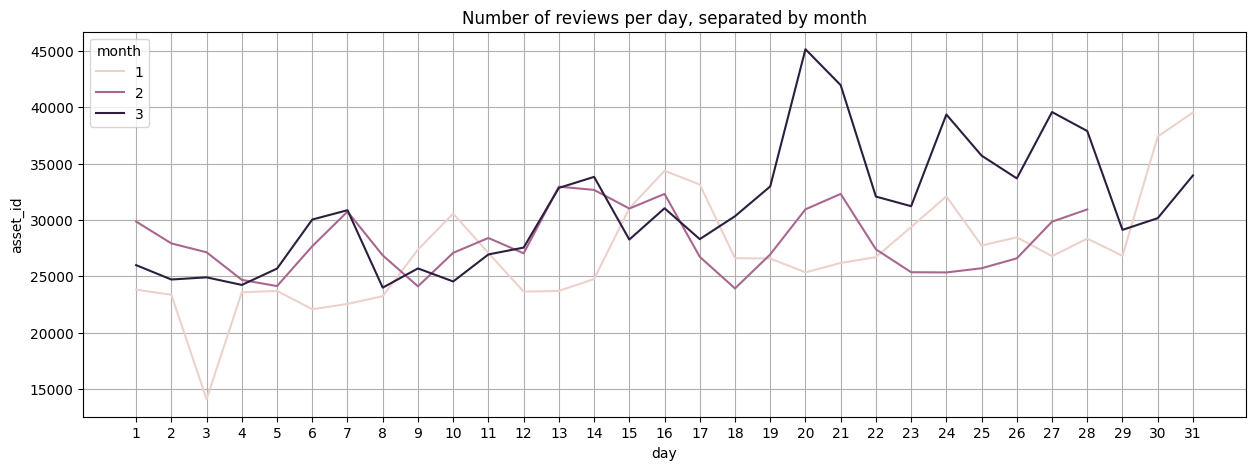

In [20]:
# there are repeated entries when 'resume' == 1, so I'm going to remove them
print(f'Number of rows before drop duplicates: {len(df)}')
df_drop = df.drop_duplicates(subset=['account_id', 'asset_id'], keep='last')
print(f'Number of rows after drop duplicates: {len(df_drop)}')

# ploting visualizations/day-month with removed data
aux = df_drop.copy()
aux['year'] = df['tunein'].dt.year
aux['month'] = df['tunein'].dt.month
aux['day'] = df['tunein'].dt.day
aux = aux.groupby(['month', 'day'], as_index=False)\
    .count()[['month', 'day', 'asset_id']]

plt.figure(figsize=(15,5))
sns.lineplot(data=aux, x='day', y='asset_id', hue='month')
plt.title("Number of reviews per day, separated by month")
plt.xticks([x for x in range(aux['day'].min(), aux['day'].max() +1,1)])
plt.grid(0.3)
plt.show()

In [21]:
print(f'n_entries: {len(df_drop)}')
print(f'n liked entries watch: {df_drop["rate_watch"].sum()}')
print(f'n liked entries watch and rewatch {df_drop["rate_watchANDrewatch"].sum()}')

n_entries: 2589616
n liked entries watch: 1200087
n liked entries watch and rewatch 1602344


In [22]:
# there are repeated entries when 'resume' == 1, so I'm going to remove them
df_drop = df.drop_duplicates(subset=['account_id', 'asset_id'], keep='last')

# grouping by 'account_id' and 'content_id' because the recomendations must be by 'content_id' and not 'asset_id'
df_drop = df_drop.groupby(['account_id', 'content_id'], as_index=False)\
            .agg({'account_id': 'mean',
                  'content_id': 'mean',
                  'rate_watch': 'mean',
                  'rate_watchANDrewatch': 'mean',
                  'tunein': (lambda x: x.iloc[0]), # keep the first value
                  'end_vod_date': (lambda x: x.iloc[0]) # keep the first value
                  })

# in tv programs (Series), the rate will be an average of episodes, so it needs to be converted to 0s and 1s values
df_drop['rate_watch'] = df_drop['rate_watch'].apply(lambda x: 0 if x < 0.5 else 1)
df_drop['rate_watchANDrewatch'] = df_drop['rate_watchANDrewatch'].apply(lambda x: 0 if x < 0.5 else 1)
df_drop.head(2)

,account_id,content_id,rate_watch,rate_watchANDrewatch,tunein,end_vod_date
0,0.0,1503.0,1,1,2021-01-18 15:21:00,2021-03-05 23:59:59
1,0.0,2866.0,0,1,2021-01-13 00:12:00,2021-12-31 23:59:59


In [23]:
# lightfm model needs -1 for not like and 1 for like
df_drop['rate_watch'] = df_drop['rate_watch'].apply(lambda x: -1 if x == 0 else 1)
df_drop['rate_watchANDrewatch'] = df_drop['rate_watchANDrewatch'].apply(lambda x: -1 if x == 0 else 1)

# train test split
train = df_drop[df_drop['tunein'] < datetime(year=2021, month=3, day=1)]
test = df_drop[df_drop['tunein'] >= datetime(year=2021, month=3, day=1)]
print(f'Length train: {len(train)}')
print(f'Length test: {len(test)}')
print(f'Number of unique account_id in train: {train["account_id"].nunique()}')
print(f'Number of unique account_id in test: {test["account_id"].nunique()}')

Length train: 655011
Length test: 316443
Number of unique account_id in train: 99252
Number of unique account_id in test: 80408


In [24]:
# loocking for account_id in test but not in train (cold start)
print(f'There are \
{test[~test["account_id"].isin(train["account_id"].unique())]["account_id"].nunique()} \
account_ids who are in test but not in train')

There are 14621 account_ids who are in test but not in train


In [25]:
# interaction matrix
interactions = train[['account_id', 'content_id', 'rate_watch']] # features
interactions_matrix = interactions.pivot(index='account_id', columns='content_id', values='rate_watch') # matrix creation
interactions_matrix = interactions_matrix.fillna(0) # fill na interactions_matrix
interactions_matrix_csr = csr_matrix(interactions_matrix.values) # sparsing interactions_matrix

print(f'Size interactions_matrix (bytes): {sys.getsizeof(interactions_matrix)}')
print(f'Size interactions_matrix_csr (bytes): {sys.getsizeof(interactions_matrix_csr)}')

Size interactions_matrix (bytes): 2930713080
Size interactions_matrix_csr (bytes): 56


# modeling

In [26]:
watch_model = LightFM(no_components=3, learning_rate=0.03, random_state=42)
watch_model = watch_model.fit(interactions_matrix_csr, epochs=50)

In [40]:
n_users, n_items = interactions_matrix.shape[1]
item_ids = np.arange(interactions_matrix.shape[1])
len(item_ids)

3690

In [43]:
item_ids[0:25]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24])

In [41]:
len(interactions_matrix.columns)

3690

In [47]:
list(interactions_matrix.columns)[0:25]

[0.0,
 1.0,
 3.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 18.0,
 19.0,
 20.0,
 22.0,
 23.0,
 24.0,
 26.0,
 33.0,
 36.0,
 37.0,
 38.0,
 39.0,
 40.0]

In [ ]:
# lightfm model needs -1 for not like and 1 for like
df_drop['rate_watch'] = df_drop['rate_watch'].apply(lambda x: -1 if x == 0 else 1)
df_drop['rate_watchANDrewatch'] = df_drop['rate_watchANDrewatch'].apply(lambda x: -1 if x == 0 else 1)

# train test split
train = df_drop[df_drop['tunein'] < datetime(year=2021, month=3, day=1)]
test = df_drop[df_drop['tunein'] >= datetime(year=2021, month=3, day=1)]
print(f'Length train: {len(train)}')
print(f'Length test: {len(test)}')
print(f'Number of unique account_id in train: {train["account_id"].nunique()}')
print(f'Number of unique account_id in test: {test["account_id"].nunique()}')

In [59]:
not_available_content_until15march = df_drop[df_drop['end_vod_date'] < datetime(year=2021, month=3, day=15)]\
    ['content_id'].values

# cold start
most_popular_content = train.groupby('content_id', as_index=False).agg({'account_id':'nunique'})\
    .sort_values(by='account_id', ascending=False)
most_popular = most_popular_content['content_id'][0:40].values
most_popular = [x for x in most_popular if x not in not_available_content_until15march]

# creating a dict to map the account_id
account_id = list(interactions_matrix.index)
account_dict = {}
counter = 0
for i in account_id:
    account_dict[i] = counter
    counter += 1

# recomendations dict
recomendations_dict = {
    'account_id': [],
    'recomendations': []
    }

# accounts and items
accounts_train = list(interactions_matrix.index)
item_ids = list(interactions_matrix.columns) # si calculo los items asi, me da error. no deberia hacerse de esta manera?
                                             # haciendo un arange se corre el riesgo de incluir items que no estan
item_ids = np.arange(interactions_matrix.shape[1]) # si calculo los items asi, no me da error
test_accounts = test['account_id'].unique()

#por cada usuario del dataset de test, generamos recomendaciones
for account_test in tqdm(test_accounts):
    #COMPLETAR: Validar si el usuario se encuentra en la matriz de interacciones (interactions_matrix.index)
    if account_test in list(accounts_train):
        # Si el usuario esta en train, no es cold start. Usamos el modelo para recomendar
        account_x = account_dict[account_test] #buscamos el indice del usuario en la matriz (transformamos id a indice)

        #COMPLETAR: Generar las predicciones para el usuario x
        predictions = watch_model.predict(user_ids=account_x, item_ids=item_ids)

        #COMPLETAR: Basándose en el ejemplo anterior, ordenar las predicciones de menor a mayor y quedarse con 50.
        scores = pd.Series(predictions)
        scores.index = interactions_matrix.columns
        scores = list(pd.Series(scores.sort_values(ascending=False).index))[:50]

        #COMPLETAR: Obtener listado de contenidos vistos anteriormente por el usuario (en el set de train)
        watched_contents = train[train['account_id'] == account_test]['content_id'].unique()

        #COMPLETAR: Filtrar contenidos ya vistos y quedarse con el resto
        recomendations = [x for x in scores if x not in watched_contents]
        #COMPLETAR: Filtrar contenidos ya vistos y quedarse con el resto
        recomendations = [x for x in recomendations if x not in not_available_content_until15march]

        # Guardamos las recomendaciones en el diccionario
        recomendations_dict['account_id'].append(account_test)
        recomendations_dict['recomendations'].append(recomendations[0:20])

    # En este else trataremos a los usuarios que no están en la matriz (cold start)
    else:
        recomendations_dict['account_id'].append(account_test)
        # Les recomendamos contenido popular
        recomendations_dict['recomendations'].append(most_popular)

100%|██████████| 80408/80408 [05:03<00:00, 264.77it/s]


In [60]:
recomendations_df = pd.DataFrame(recomendations_dict)
recomendations_df

,account_id,recomendations
0,2.0,"[3900.0, 2160.0, 3726.0, 496.0, 562.0, 2815.0,..."
1,3.0,"[3598.0, 2040.0, 2815.0, 496.0, 562.0, 2190.0,..."
2,4.0,"[496.0, 491.0, 2172.0, 304.0, 562.0, 497.0, 18..."
3,5.0,"[496.0, 2172.0, 491.0, 497.0, 562.0, 2097.0, 1..."
4,6.0,"[496.0, 2172.0, 604.0, 562.0, 497.0, 2040.0, 4..."
...,...,...
80403,113876.0,"[2040.0, 3806.0, 3900.0, 3598.0, 2160.0, 3381...."
80404,113877.0,"[2040.0, 3806.0, 3900.0, 3598.0, 2160.0, 3381...."
80405,113878.0,"[2040.0, 3806.0, 3900.0, 3598.0, 2160.0, 3381...."
80406,113879.0,"[2040.0, 3806.0, 3900.0, 3598.0, 2160.0, 3381...."


In [30]:
df_drop[df_drop['end_vod_date'] < datetime(year=2021, month=3, day=5)]

,account_id,content_id,rate_watch,rate_watchANDrewatch,tunein,end_vod_date
5,1.0,1020.0,1,1,2021-01-01 18:37:00,2021-02-18 23:59:59
6,1.0,1220.0,0,0,2021-01-03 20:02:00,2021-01-29 23:59:00
7,1.0,1761.0,0,0,2021-01-17 22:50:00,2021-02-28 23:59:59
9,2.0,183.0,0,0,2021-01-05 11:15:00,2021-02-19 23:59:59
12,2.0,1099.0,0,1,2021-01-01 01:28:00,2021-01-15 23:59:00
...,...,...,...,...,...,...
959166,111409.0,163.0,1,1,2021-02-28 00:27:00,2021-03-04 23:59:59
959475,111463.0,1315.0,1,1,2021-02-28 14:18:00,2021-03-01 23:59:00
959503,111465.0,1758.0,0,1,2021-02-28 22:07:00,2021-02-28 23:59:00
959505,111465.0,1829.0,1,1,2021-03-02 21:28:00,2021-03-02 23:59:00
